In [645]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV, train_test_split

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import time
from datetime import datetime

In [456]:
RANDOM_STATE = 19

In [475]:
train = pd.read_csv('features.csv')
test = pd.read_csv('features_test.csv')

In [476]:
print(train.shape)
print(test.shape)

(97230, 109)
(17177, 103)


In [477]:
train.head()

,match_id,start_time,lobby_type,r1_hero,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,...,dire_boots_count,dire_ward_observer_count,dire_ward_sentry_count,dire_first_ward_time,duration,radiant_win,tower_status_radiant,tower_status_dire,barracks_status_radiant,barracks_status_dire
0,0,1430198770,7,11,5,2098,1489,20,0,0,...,4,2,2,-52.0,2874,1,1796,0,51,0
1,1,1430220345,0,42,4,1188,1033,9,0,1,...,4,3,1,-5.0,2463,1,1974,0,63,1
2,2,1430227081,7,33,4,1319,1270,22,0,0,...,4,3,1,13.0,2130,0,0,1830,0,63
3,3,1430263531,1,29,4,1779,1056,14,0,0,...,4,2,0,27.0,1459,0,1920,2047,50,63
4,4,1430282290,7,13,4,1431,1090,8,1,0,...,3,3,0,-16.0,2449,0,4,1974,3,63


### Find redudant features in train

In [478]:
redudant_feat = list(set(train.columns) - set(test.columns))
print(redudant_feat)
print(set(test.columns) - set(train.columns))

['radiant_win', 'duration', 'tower_status_dire', 'barracks_status_radiant', 'barracks_status_dire', 'tower_status_radiant']
set()


In [479]:
train, redudant = train.drop(redudant_feat, axis=1), train[redudant_feat]
y = redudant['radiant_win']

In [480]:
train.shape, test.shape

((97230, 103), (17177, 103))

### Find null values and fill them

In [481]:
print(f'{train.isna().sum().sum()} - train count nan values')
print(f'{test.isna().sum().sum()} - test count nan values')

193087 - train count nan values
34418 - test count nan values


In [482]:
[(i, train[i].isna().sum(), train[i].dtypes) for i in train.columns if train[i].isna().any()]

[('first_blood_time', 19553, dtype('float64')),
 ('first_blood_team', 19553, dtype('float64')),
 ('first_blood_player1', 19553, dtype('float64')),
 ('first_blood_player2', 43987, dtype('float64')),
 ('radiant_bottle_time', 15691, dtype('float64')),
 ('radiant_courier_time', 692, dtype('float64')),
 ('radiant_flying_courier_time', 27479, dtype('float64')),
 ('radiant_first_ward_time', 1836, dtype('float64')),
 ('dire_bottle_time', 16143, dtype('float64')),
 ('dire_courier_time', 676, dtype('float64')),
 ('dire_flying_courier_time', 26098, dtype('float64')),
 ('dire_first_ward_time', 1826, dtype('float64'))]

In [483]:
[(i, test[i].isna().sum(), test[i].dtypes) for i in test.columns if test[i].isna().any()]

[('first_blood_time', 3552, dtype('float64')),
 ('first_blood_team', 3552, dtype('float64')),
 ('first_blood_player1', 3552, dtype('float64')),
 ('first_blood_player2', 7766, dtype('float64')),
 ('radiant_bottle_time', 2895, dtype('float64')),
 ('radiant_courier_time', 127, dtype('float64')),
 ('radiant_flying_courier_time', 4885, dtype('float64')),
 ('radiant_first_ward_time', 330, dtype('float64')),
 ('dire_bottle_time', 2842, dtype('float64')),
 ('dire_courier_time', 130, dtype('float64')),
 ('dire_flying_courier_time', 4524, dtype('float64')),
 ('dire_first_ward_time', 263, dtype('float64'))]

#### fill them with zeros

In [484]:
train_not_filled = train.copy()
test_no_filles = test.copy()

In [485]:
train = train.fillna(0)
test = test.fillna(0)
print(f'{train.isna().sum().sum()} - train nan')
print(f'{test.isna().sum().sum()} - test nan')

0 - train nan
0 - test nan


### Fit Gradient Boosting

In [211]:
kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

In [212]:
boosting_params = {
    'n_estimators': [2, 5, 7, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 90]
}

In [213]:
boosting_fit_data = {}
boosting_fit_data['time'] = []
for n_estim in boosting_params['n_estimators']:
    fit_scores = []
    start_time = time.time()
    clf = GradientBoostingClassifier(n_estimators=n_estim, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    boosting_fit_data[n_estim] = fit_scores
    boosting_fit_data['time'].append(end_time - start_time)
    print(f'trees: {n_estim} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

trees: 2 | mean_roc_auc_score: 0.6108859960022477 | time: 8.199
trees: 5 | mean_roc_auc_score: 0.6348085565713358 | time: 18.999
trees: 7 | mean_roc_auc_score: 0.6519233479483159 | time: 26.265
trees: 10 | mean_roc_auc_score: 0.6651167116783963 | time: 37.291
trees: 15 | mean_roc_auc_score: 0.6763383542886326 | time: 55.596
trees: 20 | mean_roc_auc_score: 0.6822453160006683 | time: 73.352
trees: 25 | mean_roc_auc_score: 0.6866274496993864 | time: 92.612
trees: 30 | mean_roc_auc_score: 0.6895295783966826 | time: 109.754
trees: 35 | mean_roc_auc_score: 0.6920685863936097 | time: 128.278
trees: 40 | mean_roc_auc_score: 0.6938005186903434 | time: 146.448
trees: 50 | mean_roc_auc_score: 0.6974171194754433 | time: 182.494
trees: 60 | mean_roc_auc_score: 0.7002089463603418 | time: 223.538
trees: 70 | mean_roc_auc_score: 0.7021512888711224 | time: 254.654
trees: 80 | mean_roc_auc_score: 0.7041065424969771 | time: 293.743
trees: 90 | mean_roc_auc_score: 0.7054542822188086 | time: 339.324


### Fit Logistric Regression

In [225]:
log_params = {
    'Cs': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 30, 50, 100, 200, 500, 1000]
}

### scaling data

In [226]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [227]:
log_reg_fit_data = {}
log_reg_fit_data['time'] = []
for c in log_params['Cs']:
    fit_scores = []
    start_time = time.time()
    clf = LogisticRegression(C=c, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train_scaled[train_index, :], train_scaled[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    log_reg_fit_data[c] = fit_scores
    log_reg_fit_data['time'].append(end_time - start_time)
    print(f'C: {c} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

C: 0.0001 | mean_roc_auc_score: 0.7113606690065316 | time: 16.232
C: 0.001 | mean_roc_auc_score: 0.7162901774647967 | time: 29.053
C: 0.01 | mean_roc_auc_score: 0.7164185447842384 | time: 35.951
C: 0.1 | mean_roc_auc_score: 0.7163824105910583 | time: 41.035
C: 1 | mean_roc_auc_score: 0.7163792459888677 | time: 41.895
C: 2 | mean_roc_auc_score: 0.7163790320707273 | time: 41.698
C: 5 | mean_roc_auc_score: 0.7163790087464191 | time: 41.447
C: 10 | mean_roc_auc_score: 0.7163790130191336 | time: 41.936
C: 30 | mean_roc_auc_score: 0.7163788245043919 | time: 41.814
C: 50 | mean_roc_auc_score: 0.7163788689915342 | time: 40.697
C: 100 | mean_roc_auc_score: 0.7163788859360718 | time: 42.073
C: 200 | mean_roc_auc_score: 0.7163788817041061 | time: 41.172
C: 500 | mean_roc_auc_score: 0.716378907124932 | time: 41.135
C: 1000 | mean_roc_auc_score: 0.7163789092388712 | time: 40.552


### dropping categorical features

In [486]:
[i for i in train.columns if train[i].dtypes not in  ['int', 'float64']]

[]

In [487]:
str(list(train.columns))

"['match_id', 'start_time', 'lobby_type', 'r1_hero', 'r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items', 'r2_hero', 'r2_level', 'r2_xp', 'r2_gold', 'r2_lh', 'r2_kills', 'r2_deaths', 'r2_items', 'r3_hero', 'r3_level', 'r3_xp', 'r3_gold', 'r3_lh', 'r3_kills', 'r3_deaths', 'r3_items', 'r4_hero', 'r4_level', 'r4_xp', 'r4_gold', 'r4_lh', 'r4_kills', 'r4_deaths', 'r4_items', 'r5_hero', 'r5_level', 'r5_xp', 'r5_gold', 'r5_lh', 'r5_kills', 'r5_deaths', 'r5_items', 'd1_hero', 'd1_level', 'd1_xp', 'd1_gold', 'd1_lh', 'd1_kills', 'd1_deaths', 'd1_items', 'd2_hero', 'd2_level', 'd2_xp', 'd2_gold', 'd2_lh', 'd2_kills', 'd2_deaths', 'd2_items', 'd3_hero', 'd3_level', 'd3_xp', 'd3_gold', 'd3_lh', 'd3_kills', 'd3_deaths', 'd3_items', 'd4_hero', 'd4_level', 'd4_xp', 'd4_gold', 'd4_lh', 'd4_kills', 'd4_deaths', 'd4_items', 'd5_hero', 'd5_level', 'd5_xp', 'd5_gold', 'd5_lh', 'd5_kills', 'd5_deaths', 'd5_items', 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'firs

In [488]:
r_heros_feat = [f'r{i}_hero' for i in range(1, 6)]
d_heros_feat = [f'd{i}_hero' for i in range(1, 6)]

In [471]:
train = train_saved_2.copy()
test = test_saved_2.copy()

In [489]:
not_numeric_features = ['match_id', 'start_time'] + r_heros_feat + d_heros_feat

In [490]:
train_saved_2 = train.copy()
test_saved_2 = test.copy()

In [491]:
train = train.drop(not_numeric_features, axis=1)
test = test.drop(not_numeric_features, axis=1)

In [492]:
print(train.shape)
print(test.shape)

(97230, 91)
(17177, 91)


### fit log reg with dropped cat features

In [291]:
log_params_2 = {
    'Cs': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 30, 50, 100, 200, 500, 1000]
}

In [292]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [293]:
log_reg_fit_data_2 = {}
log_reg_fit_data_2['time'] = []
for c in log_params_2['Cs']:
    fit_scores = []
    start_time = time.time()
    clf = LogisticRegression(C=c, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train_scaled[train_index, :], train_scaled[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    log_reg_fit_data_2[c] = fit_scores
    log_reg_fit_data_2['time'].append(end_time - start_time)
    print(f'C: {c} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

C: 0.0001 | mean_roc_auc_score: 0.711161465800447 | time: 18.679
C: 0.001 | mean_roc_auc_score: 0.7161227205540363 | time: 24.466
C: 0.01 | mean_roc_auc_score: 0.7162634407607051 | time: 32.752
C: 0.1 | mean_roc_auc_score: 0.7162319239914208 | time: 36.03
C: 1 | mean_roc_auc_score: 0.7162269397842534 | time: 37.179
C: 2 | mean_roc_auc_score: 0.7162263890671741 | time: 34.196
C: 5 | mean_roc_auc_score: 0.7162263721266499 | time: 35.776
C: 10 | mean_roc_auc_score: 0.7162259420351422 | time: 35.284
C: 30 | mean_roc_auc_score: 0.7162259059766065 | time: 36.079
C: 50 | mean_roc_auc_score: 0.7162257851941554 | time: 35.081
C: 100 | mean_roc_auc_score: 0.7162255372228701 | time: 33.442
C: 200 | mean_roc_auc_score: 0.7162255689752589 | time: 34.806
C: 500 | mean_roc_auc_score: 0.716225577468439 | time: 35.667
C: 1000 | mean_roc_auc_score: 0.7162256007773308 | time: 36.101


#### see best coefficients

In [306]:
pd.DataFrame(abs(clf.coef_.T), train.columns, columns=['coefs']).sort_values(by='coefs', ascending=False)

,coefs
r2_gold,0.236646
d2_gold,0.233368
d1_gold,0.233345
r1_gold,0.220232
d4_gold,0.218176
...,...
r1_kills,0.000879
first_blood_time,0.000768
r1_deaths,0.000597
d4_deaths,0.000088


In [493]:
train = train_saved_2.copy()
test = test_saved_2.copy()

### check unique heros

In [494]:
train_backup = train.copy()
test_backup = test.copy()

In [556]:
train = train_saved_2
test = test_saved_2

##### heros not played in all matches

In [495]:
unique_heros = []
for i in range(1, 6):
    unique_heros = set(list(unique_heros) + list(train[f'r{i}_hero'].unique()) + list(train[f'd{i}_hero'].unique()))
    
for i in range(1, 114):
    if i not in unique_heros:
        print(i)

24
107
108
111
113


In [643]:
n_unique_heros = len(unique_heros)
print(f'{n_unique_heros} - number of unique heros in train games')

108 - number of unique heros in train games


### Add bag of workds of heros

In [496]:
def get_back_of_heros(df):
    X_pick = {}
    for id in unique_heros:
        radians = [(df[f'r{i}_hero'] == id) + 0 for i in range(1, 6)]
        dires = [(df[f'd{i}_hero'] == id) + 0 for i in range(1, 6)]
        X_pick[f'hero_{id}'] = sum(radians) - sum(dires)
    X_pick = pd.DataFrame(X_pick)
    return X_pick

In [557]:
train_bag_heros = get_back_of_heros(train)
test_bag_heros = get_back_of_heros(test)

In [558]:
train = train_backup.copy()
test = test_backup.copy()

In [559]:
train = pd.concat([train, train_bag_heros], axis=1)
test = pd.concat([test, test_bag_heros], axis=1)

In [560]:
print(train.shape)
print(test.shape)

(97230, 211)
(17177, 211)


### Fit Logistric Regression with new features

In [514]:
log_params = {
    'Cs': [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10, 30, 50, 100, 200, 500, 1000, 5000, 10000, 50000, 100000, 1e6]
}

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


log_reg_fit_data_3 = {}
log_reg_fit_data_3['time'] = []
for c in log_params['Cs']:
    fit_scores = []
    start_time = time.time()
    clf = LogisticRegression(C=c, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train_scaled[train_index, :], train_scaled[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    log_reg_fit_data_3[c] = fit_scores
    log_reg_fit_data_3['time'].append(end_time - start_time)
    print(f'C: {c} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

C: 0.0001 | mean_roc_auc_score: 0.7425823346781367 | time: 37.142
C: 0.001 | mean_roc_auc_score: 0.751340084364829 | time: 65.72
C: 0.01 | mean_roc_auc_score: 0.7516258861499664 | time: 98.047
C: 0.1 | mean_roc_auc_score: 0.7515842137333841 | time: 106.912
C: 1 | mean_roc_auc_score: 0.7515788597168631 | time: 105.651
C: 2 | mean_roc_auc_score: 0.751578406287255 | time: 103.205
C: 5 | mean_roc_auc_score: 0.7515778683076813 | time: 102.77
C: 10 | mean_roc_auc_score: 0.7515773599573792 | time: 101.681
C: 30 | mean_roc_auc_score: 0.7515781077634773 | time: 105.234
C: 50 | mean_roc_auc_score: 0.7515781798073353 | time: 102.992
C: 100 | mean_roc_auc_score: 0.7515781586039031 | time: 103.116
C: 200 | mean_roc_auc_score: 0.751578131045924 | time: 101.722
C: 500 | mean_roc_auc_score: 0.7515781289275851 | time: 104.024
C: 1000 | mean_roc_auc_score: 0.7515781670647861 | time: 104.13
C: 5000 | mean_roc_auc_score: 0.7515782285063262 | time: 102.672
C: 10000 | mean_roc_auc_score: 0.7515782285072597 

### find best fit params

In [533]:
max_score = 0
max_c = 0
for c in log_params['Cs']:
    mean_value = np.mean(log_reg_fit_data_3[c])
    if mean_value > max_score:
        max_score = mean_value
        max_c = c
    
print(f'max_score: {max_score} | c: {max_c}')

max_score: 0.7516258861499664 | c: 0.01


### Make predictions on train test split

In [561]:
print(train.shape)
print(test.shape)

(97230, 211)
(17177, 211)


In [562]:
train_ready = train.copy()
test_ready = test.copy()

In [563]:
train = train.drop(['match_id', 'start_time'], axis=1)
test = test.drop(['match_id', 'start_time'], axis=1)

In [564]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

In [565]:
X_train, X_val, y_train, y_val = train_test_split(train_scaled, y, test_size=0.3, random_state=RANDOM_STATE)
best_model = LogisticRegression(C=0.01, random_state=RANDOM_STATE, n_jobs=-1)
best_model.fit(X_train, y_train)
pred = best_model.predict_proba(X_train)[:, 1]
score = roc_auc_score(y_train, pred)
score

0.7536818163296071

### Fit best model on all train data

In [568]:
best_model = LogisticRegression(C=0.01, random_state=RANDOM_STATE, n_jobs=-1)
best_model.fit(train_scaled, y)

LogisticRegression(C=0.01, n_jobs=-1, random_state=19)

### Make predictions on test data

In [569]:
pred = best_model.predict_proba(test_scaled)[:, 1]
pred

array([0.83471649, 0.7740997 , 0.20741367, ..., 0.23070545, 0.62068732,
       0.42061198])

### Prepare predictions for kaggle

In [580]:
predictions = pd.DataFrame(pred, test_ready.match_id, columns=['radiant_win'])
predictions.to_csv('log_reg_pred.csv')
predictions.head()

,radiant_win
match_id,
6,0.834716
7,0.774100
10,0.207414
13,0.863928
16,0.259246


### Try some more staff

In [584]:
train_stored_last = train.copy()
test_stored_last = test.copy()

In [586]:
train = train.drop(r_heros_feat + d_heros_feat, axis=1)
test = test.drop(r_heros_feat + d_heros_feat, axis=1)

In [591]:
print(train.lobby_type.value_counts())
print(test.lobby_type.value_counts())

1    55962
7    28550
0    12718
Name: lobby_type, dtype: int64
1    9857
7    5029
0    2291
Name: lobby_type, dtype: int64


In [592]:
train.head()

,lobby_type,r1_level,r1_xp,r1_gold,r1_lh,r1_kills,r1_deaths,r1_items,r2_level,r2_xp,...,hero_100,hero_101,hero_102,hero_103,hero_104,hero_105,hero_106,hero_109,hero_110,hero_112
0,7,5,2098,1489,20,0,0,7,3,842,...,0,0,0,0,0,1,0,0,0,0
1,0,4,1188,1033,9,0,1,12,4,1596,...,0,0,0,0,0,0,0,0,0,0
2,7,4,1319,1270,22,0,0,12,3,1314,...,0,0,0,0,0,0,0,0,0,0
3,1,4,1779,1056,14,0,0,5,2,539,...,0,0,-1,0,0,0,0,0,0,0
4,7,4,1431,1090,8,1,0,8,2,629,...,0,0,0,0,0,0,0,0,0,0


In [595]:
def lobbies_one_hot(df):
    df = df.copy()
    df = pd.get_dummies(df, columns=['lobby_type'])
    return df

In [596]:
train = lobbies_one_hot(train)
test = lobbies_one_hot(test)

### Make agregating features

In [615]:
def make_agregatting_feature(df, team, feature):
    df = df.copy()
    df[f'{team}_team_total_{feature}'] = df[[f'{team}{i}_{feature}' for i in range(1, 6)]].sum(axis=1)
    return df

In [624]:
features_to_aggregate = ['level', 'xp', 'gold', 'lh', 'kills', 'deaths', 'items']

In [625]:
for feat in features_to_aggregate:
    train = make_agregatting_feature(train, 'r', feat)
    train = make_agregatting_feature(train, 'd', feat)
    test = make_agregatting_feature(train, 'r', feat)
    test = make_agregatting_feature(train, 'd', feat)

In [627]:
print(train.shape)
print(test.shape)

(97230, 215)
(97230, 215)


### fit model with aggregated features

In [629]:
log_params = {
    'Cs': [0.0001, 0.001, 0.01, 0.1, 1]
}

scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


log_reg_fit_data_agg = {}
log_reg_fit_data_agg['time'] = []
for c in log_params['Cs']:
    fit_scores = []
    start_time = time.time()
    clf = LogisticRegression(C=c, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train_scaled[train_index, :], train_scaled[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    log_reg_fit_data_agg[c] = fit_scores
    log_reg_fit_data_agg['time'].append(end_time - start_time)
    print(f'C: {c} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

C: 0.0001 | mean_roc_auc_score: 0.7470184216398439 | time: 41.419
C: 0.001 | mean_roc_auc_score: 0.7517332197395146 | time: 63.93
C: 0.01 | mean_roc_auc_score: 0.7517217292220842 | time: 83.474
C: 0.1 | mean_roc_auc_score: 0.7516842747578159 | time: 91.242
C: 1 | mean_roc_auc_score: 0.7516787138904558 | time: 89.192


### grad boosting with new features with XGBoost

In [654]:
boosting_params = {
    'max_depth': [2, 3, 4, 5, 7, 9, 10, 15]
}

In [642]:
boosting_fit_data_agg = {}
boosting_fit_data_agg['time'] = []
for depth in boosting_params['max_depth']:
    fit_scores = []
    start_time = time.time()
    clf = XGBClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    boosting_fit_data_agg[n_estim] = fit_scores
    boosting_fit_data_agg['time'].append(end_time - start_time)
    print(f'depths: {depth} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

depths: 2 | mean_roc_auc_score: 0.7292331326627632 | time: 149.048
depths: 3 | mean_roc_auc_score: 0.7349157588022399 | time: 205.548
depths: 4 | mean_roc_auc_score: 0.7384862070010442 | time: 266.136
depths: 5 | mean_roc_auc_score: 0.7405821928582855 | time: 329.844
depths: 7 | mean_roc_auc_score: 0.7408277270854573 | time: 478.447
depths: 9 | mean_roc_auc_score: 0.7374123792717334 | time: 642.769
depths: 10 | mean_roc_auc_score: 0.735258637718479 | time: 709.461
depths: 15 | mean_roc_auc_score: 0.7290370691167196 | time: 1140.509


KeyboardInterrupt: 

### check middle values

In [655]:
boosting_params = {
    'max_depth': [5, 6, 7, 8]
}

boosting_fit_data_agg = {}
boosting_fit_data_agg['time'] = []
for depth in boosting_params['max_depth']:
    fit_scores = []
    start_time = time.time()
    clf = XGBClassifier(n_estimators=100, max_depth=depth, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    boosting_fit_data_agg[n_estim] = fit_scores
    boosting_fit_data_agg['time'].append(end_time - start_time)
    print(f'depths: {depth} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)}')

depths: 5 | mean_roc_auc_score: 0.7405821928582855 | time: 315.581
depths: 6 | mean_roc_auc_score: 0.7410978110585024 | time: 371.164
depths: 7 | mean_roc_auc_score: 0.7408277270854573 | time: 432.852
depths: 8 | mean_roc_auc_score: 0.739461018305997 | time: 520.173


#### ass see below best score with depths = 6

### configure best trees number

In [657]:
boosting_params = {
    'n_estimators': [10, 20, 30, 40, 50, 75, 100, 130, 170, 200, 250, 300, 350]
}

In [659]:
boosting_fit_data_agg_2 = {}
boosting_fit_data_agg_2['time'] = []
for n_trees in boosting_params['n_estimators']:
    fit_scores = []
    start_time = time.time()
    clf = XGBClassifier(n_estimators=n_trees, max_depth=depth, n_jobs=-1, random_state=RANDOM_STATE)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        clf.fit(X_train, y_train)
        pred = clf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    end_time_now = datetime.now().strftime('%H:%M:%S')
    boosting_fit_data_agg_2[n_trees] = fit_scores
    boosting_fit_data_agg_2['time'].append(end_time - start_time)
    
    print(f'n_estimators: {n_trees} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)} | {end_time_now}')

n_estimators: 10 | mean_roc_auc_score: 0.7187030542530424 | time: 64.748 | 21:07:05
n_estimators: 20 | mean_roc_auc_score: 0.7247117293597246 | time: 118.802 | 21:09:04
n_estimators: 30 | mean_roc_auc_score: 0.7292848329849209 | time: 178.38 | 21:12:02
n_estimators: 40 | mean_roc_auc_score: 0.7326281654255896 | time: 236.994 | 21:15:59
n_estimators: 50 | mean_roc_auc_score: 0.7350784062315859 | time: 271.945 | 21:20:31
n_estimators: 75 | mean_roc_auc_score: 0.7383665226681654 | time: 401.493 | 21:27:12
n_estimators: 100 | mean_roc_auc_score: 0.739461018305997 | time: 521.427 | 21:35:54
n_estimators: 130 | mean_roc_auc_score: 0.7401471277814156 | time: 692.811 | 21:47:27
n_estimators: 170 | mean_roc_auc_score: 0.7399667191866087 | time: 863.468 | 22:01:50
n_estimators: 200 | mean_roc_auc_score: 0.7398087794023297 | time: 1037.327 | 22:19:08
n_estimators: 250 | mean_roc_auc_score: 0.7393829321252229 | time: 1309.193 | 22:40:57
n_estimators: 300 | mean_roc_auc_score: 0.7386295435739824 | 

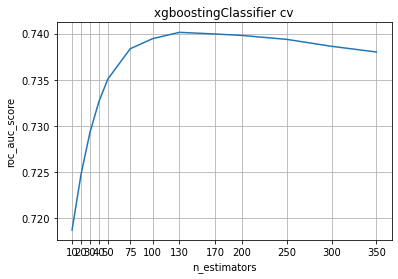

In [694]:
values = [np.mean(boosting_fit_data_agg_2[i]) for i in list(boosting_fit_data_agg_2.keys())[1:]]
plt.plot(list(boosting_fit_data_agg_2.keys())[1:], values);
plt.xlabel('n_estimators');
plt.ylabel('roc_auc_score');
plt.title('xgboostingClassifier cv');
plt.xticks(boosting_params['n_estimators'])
plt.grid(True)

### Fit Random Forest

In [697]:
forest_params = {
    'max_depth': [5, 10, 30, 60, None]
}

In [709]:
forest_fit_data = {}
forest_fit_data['time'] = []
for depth in forest_params['max_depth']:
    fit_scores = []
    start_time = time.time()
    rf = RandomForestClassifier(max_features=0.4, max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        pred = rf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    end_time_now = datetime.now().strftime('%H:%M:%S')
    forest_fit_data[n_trees] = fit_scores
    forest_fit_data['time'].append(end_time - start_time)
    
    print(f'max_depth: {depth} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)} | {end_time_now}')

max_depth: 5 | mean_roc_auc_score: 0.7132386400135946 | time: 118.117 | 00:18:12
max_depth: 10 | mean_roc_auc_score: 0.719511669645794 | time: 241.371 | 00:22:13
max_depth: 30 | mean_roc_auc_score: 0.7149464050580535 | time: 490.143 | 00:30:23
max_depth: 60 | mean_roc_auc_score: 0.7152965199163764 | time: 487.791 | 00:38:31
max_depth: None | mean_roc_auc_score: 0.7152965199163764 | time: 472.338 | 00:46:23


### Fit Random Forest with all features

In [710]:
forest_params = {
    'max_depth': [10, 15, 20, 30, 60, None]
}

In [711]:
forest_fit_data_2 = {}
forest_fit_data_2['time'] = []
for depth in forest_params['max_depth']:
    fit_scores = []
    start_time = time.time()
    rf = RandomForestClassifier(max_depth=depth, random_state=RANDOM_STATE, n_jobs=-1)
    for train_index, test_index in kf.split(train):
        X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]
        rf.fit(X_train, y_train)
        pred = rf.predict_proba(X_test)[:, 1]
        score = roc_auc_score(y_test, pred)
        fit_scores.append(score)
    end_time = time.time()
    end_time_now = datetime.now().strftime('%H:%M:%S')
    forest_fit_data_2[n_trees] = fit_scores
    forest_fit_data_2['time'].append(end_time - start_time)
    
    print(f'max_depth: {depth} | mean_roc_auc_score: {np.mean(fit_scores)} | time: {round(end_time - start_time, 3)} | {end_time_now}')

max_depth: 10 | mean_roc_auc_score: 0.7163393573757415 | time: 46.731 | 00:48:57
max_depth: 15 | mean_roc_auc_score: 0.7170641796088498 | time: 68.44 | 00:50:05
max_depth: 20 | mean_roc_auc_score: 0.71532423287012 | time: 73.112 | 00:51:18
max_depth: 30 | mean_roc_auc_score: 0.7124605063872591 | time: 86.559 | 00:52:45
max_depth: 60 | mean_roc_auc_score: 0.7119476290406107 | time: 90.653 | 00:54:16
max_depth: None | mean_roc_auc_score: 0.7119069038040975 | time: 92.898 | 00:55:49


### All features

In [599]:
str(list(train.columns))

"['r1_level', 'r1_xp', 'r1_gold', 'r1_lh', 'r1_kills', 'r1_deaths', 'r1_items', 'r2_level', 'r2_xp', 'r2_gold', 'r2_lh', 'r2_kills', 'r2_deaths', 'r2_items', 'r3_level', 'r3_xp', 'r3_gold', 'r3_lh', 'r3_kills', 'r3_deaths', 'r3_items', 'r4_level', 'r4_xp', 'r4_gold', 'r4_lh', 'r4_kills', 'r4_deaths', 'r4_items', 'r5_level', 'r5_xp', 'r5_gold', 'r5_lh', 'r5_kills', 'r5_deaths', 'r5_items', 'd1_level', 'd1_xp', 'd1_gold', 'd1_lh', 'd1_kills', 'd1_deaths', 'd1_items', 'd2_level', 'd2_xp', 'd2_gold', 'd2_lh', 'd2_kills', 'd2_deaths', 'd2_items', 'd3_level', 'd3_xp', 'd3_gold', 'd3_lh', 'd3_kills', 'd3_deaths', 'd3_items', 'd4_level', 'd4_xp', 'd4_gold', 'd4_lh', 'd4_kills', 'd4_deaths', 'd4_items', 'd5_level', 'd5_xp', 'd5_gold', 'd5_lh', 'd5_kills', 'd5_deaths', 'd5_items', 'first_blood_time', 'first_blood_team', 'first_blood_player1', 'first_blood_player2', 'radiant_bottle_time', 'radiant_courier_time', 'radiant_flying_courier_time', 'radiant_tpscroll_count', 'radiant_boots_count', 'radi